# **Q1. Applying Variational Autoencoder on CIFAR10 Dataset**

# **Import neccesary Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import keras

# **Q1 a. Building and Training VAE Model with Custom Architectures**

## **Sampling Layer for Variational Autoencoder**

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## **Encoder Architecture for Variational Autoencoder  with 4 Convolutional Layers**

In [ ]:
# Define the encoder
latent_dim = 100  # Size of the latent space

# Input layer for the encoder
encoder_inputs = keras.Input(shape=(32, 32, 3))

# First convolutional layer
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)

# Second convolutional layer
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

# Third convolutional layer
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)

# Fourth convolutional layer
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)

# Flatten layer to prepare for dense layers
x = layers.Flatten()(x)

# Dense layer for encoding
x = layers.Dense(16, activation="relu")(x)

# Output layers for z_mean and z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer to sample z from z_mean and z_log_var
z = Sampling()([z_mean, z_log_var])

# Define the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Display the encoder summary
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 16, 16, 32)           896       ['input_9[0][0]']             
                                                                                                  
 conv2d_17 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_17[0][0]']           
                                                                                            

## **Decoder Architecture for Variational Autoencoder with 4 Deconvolutional Layers**

In [ ]:
# Input layer for the decoder
latent_inputs = keras.Input(shape=(latent_dim,))

# Dense layer to start with, reshaped to 8x8x256
x = layers.Dense(8 * 8 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 256))(x)

# First deconvolutional layer, upsampling to 16x16
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding='same')(x)

# Second deconvolutional layer, upsampling to 32x32
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding='same')(x)

# Third deconvolutional layer, maintaining size but preparing for 3-channel output
x = layers.Conv2DTranspose(32, 3, activation="relu", padding='same')(x)

# Output layer to convert back to 32x32x3
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding='same')(x)

# Define the decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Display the decoder summary
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_9 (Dense)             (None, 16384)             1654784   
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 16, 16, 128)       295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 32, 32, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_18 (Conv2  (None, 32, 32, 32)        1846

## **Variational Autoencoder (VAE) Model Class**

In [ ]:
class VAE(keras.Model):
    """
    Variational Autoencoder (VAE) model class.

    This class inherits from keras.Model and includes methods for training
    the VAE model, calculating loss, and tracking metrics during training.
    """

    def __init__(self, encoder, decoder, **kwargs):
        """
        Initializes the VAE model.

        Args:
        - encoder: The encoder model.
        - decoder: The decoder model.
        - **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Returns a list of metrics tracked during training.

        Returns:
        - List of metrics including total loss, reconstruction loss, and KL divergence loss.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """
        Performs a single training step on the VAE model.

        Args:
        - data: Input data for training.

        Returns:
        - Dictionary containing loss and metric values.
        """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Scale the KL loss
            beta = 0.0001
            total_loss = reconstruction_loss + beta * kl_loss

        # Compute gradients and apply optimizer
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## **Loading CIFAR10 Dataset, Normalizing and Training VAE Model**

In [ ]:
# Load CIFAR10 data
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

#Concatenation of Train and Test Images and Normalization
cifar10_images = np.concatenate([x_train, x_test], axis=0)
cifar10_images = cifar10_images.astype("float32") / 255

#Loading encoder and decoder from above
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam())

# Fit the VAE on the CIFAR10 images
vae_model.fit(cifar10_images, epochs=150, batch_size=128)

Epoch 1/150
469/469 [==============================] - 47s 94ms/step - loss: 621.5588 - reconstruction_loss: 616.4129 - kl_loss: 480.6055
Epoch 2/150
469/469 [==============================] - 44s 94ms/step - loss: 614.7607 - reconstruction_loss: 614.4384 - kl_loss: 489.3026
Epoch 3/150
469/469 [==============================] - 45s 95ms/step - loss: 613.9264 - reconstruction_loss: 614.0909 - kl_loss: 494.1844
Epoch 4/150
469/469 [==============================] - 45s 96ms/step - loss: 613.3423 - reconstruction_loss: 613.7871 - kl_loss: 501.8568
Epoch 5/150
469/469 [==============================] - 45s 96ms/step - loss: 614.0414 - reconstruction_loss: 613.4565 - kl_loss: 509.5653
Epoch 6/150
469/469 [==============================] - 45s 95ms/step - loss: 613.7844 - reconstruction_loss: 613.1641 - kl_loss: 514.4086
Epoch 7/150
469/469 [==============================] - 45s 96ms/step - loss: 612.7188 - reconstruction_loss: 612.8812 - kl_loss: 526.5938
Epoch 8/150
469/469 [=============

## **Q1 b. Visualizing Latent Space Clusters for Different Classes**

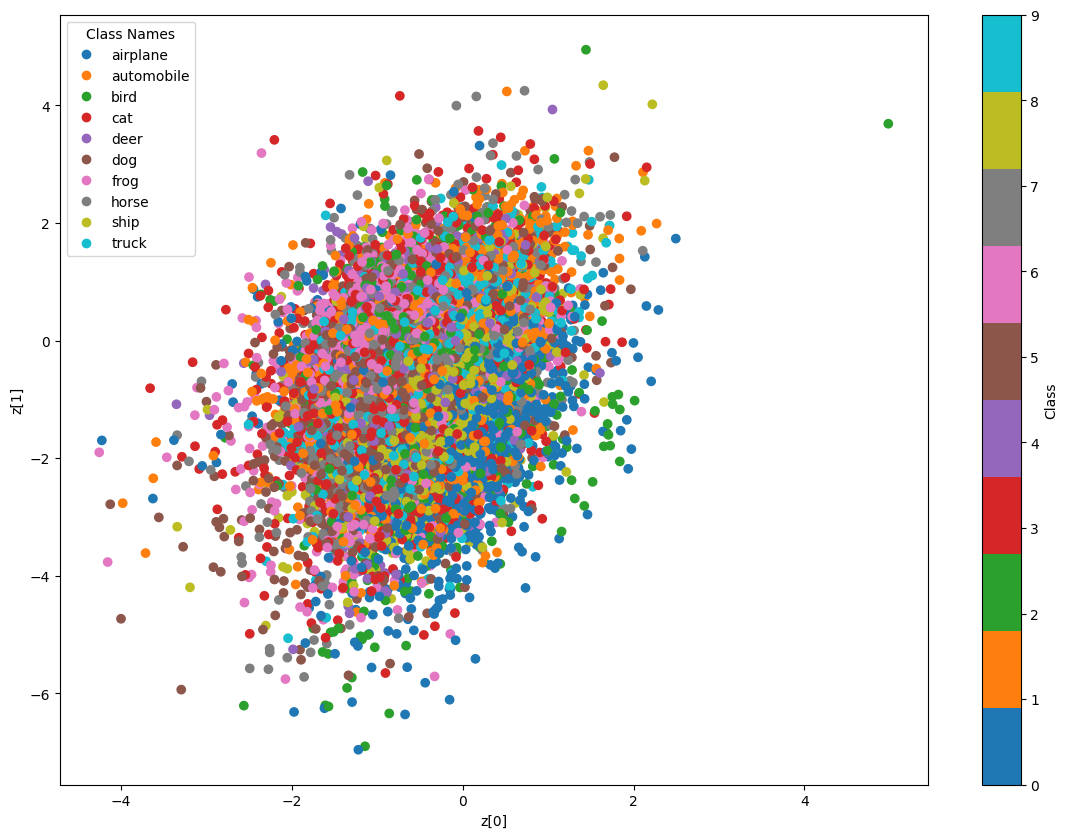

In [ ]:
def plot_label_clusters(vae, data, labels):
    # Display a 2D plot of the classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)

    # Define class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter, ticks=np.arange(10), label='Class')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title='Class Names')
    plt.show()

# Load CIFAR10 data
(x_train, y_train), _ = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255

# Flatten the labels array for color mapping in scatter plot
y_train_flat = y_train.flatten()

plot_label_clusters(vae_model, x_train, y_train_flat)



## **Display a grid of sampled images**


1/1 [==============================] - 0s 25ms/step


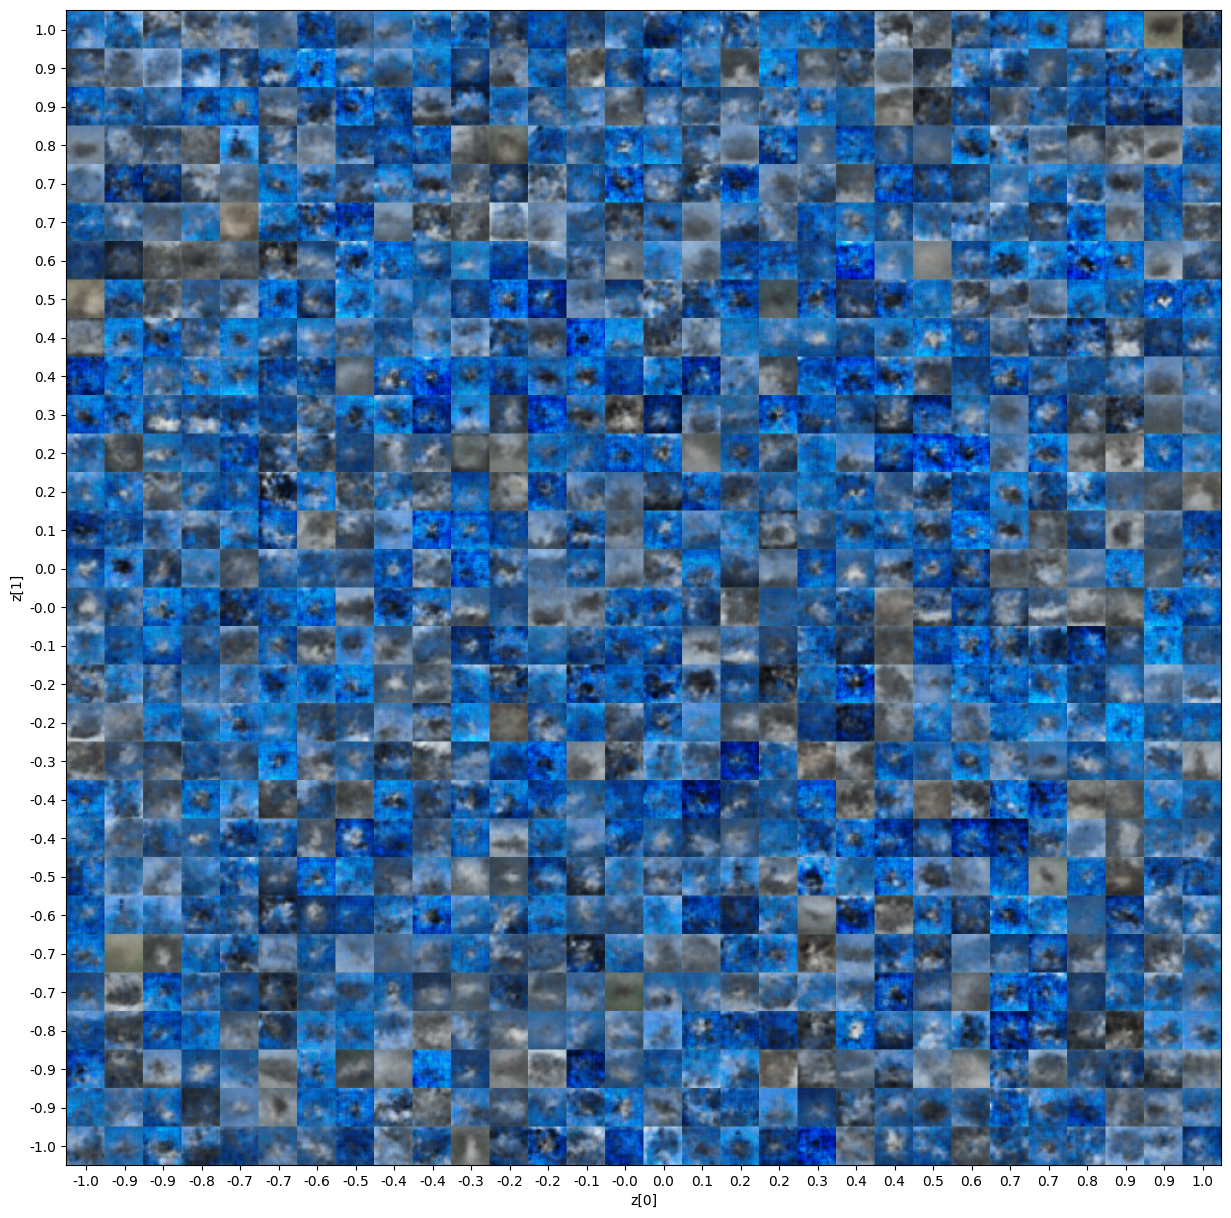

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # Display an n*n 2D manifold of CIFAR10 images
    image_size = 32  # CIFAR10 images are 32x32 pixels
    scale = 1.0
    # Initialize the figure with 3 channels for RGB
    figure = np.zeros((image_size * n, image_size * n, 3))
    # Linearly spaced coordinates corresponding to the 2D plot
    # of classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Generate a random latent vector of size 100
            z_sample = np.random.normal(size=(1, 100))
            x_decoded = vae.decoder.predict(z_sample)
            image = x_decoded[0].reshape(image_size, image_size, 3)
            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = image

    plt.figure(figsize=(figsize, figsize))
    start_range = image_size // 2
    end_range = (n - 1) * image_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, image_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()

plot_latent_space(vae_model)

## **The above image illustrates a series of samples generated by a VAE, each linked to distinct coordinates within the z[0] and z[1] two-dimensional subspace, despite the model being trained on a more complex 100-dimensional latent space. This snapshot provides a glimpse into the broader capabilities of the model, hinting at the intricate variations that the remaining 98 dimensions might encapsulate and influence within the dataset.**